In [1]:
%pylab inline
import numpy as np
import scipy as sc
import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import math
import scipy.stats as ss
from scipy import sparse

from ABC_algorithm import ABC 
from ABC_algorithm import ABC 
from post_adjustment import PostProcess

import statsmodels as sm
from sklearn.linear_model import LinearRegression


Populating the interactive namespace from numpy and matplotlib


## GK Example

In [2]:
######
# Simulate data from a GK distribution
######

def SimulateGK(n, param):  #B>0, K>-1/2 #param is a vector of A, B, g, k
    A, B, g, k = param[0], param[1], param[2], param[3]
    u_values = np.random.uniform(low=0.0, high=1.0, size=n)
    x_values = np.zeros(n)
    for i in range(0,n):
        x_values[i] = A + B*(1+0.8*(1-np.exp(-g*sc.stats.norm.ppf(u_values[i], 0, 1) )) /(1 + np.exp(-g*sc.stats.norm.ppf(u_values[i], 0, 1) ))) *np.power((1+ np.power(sc.stats.norm.ppf(u_values[i], 0, 1),2)),k)*(sc.stats.norm.ppf(u_values[i], 0, 1))    
    return x_values

# param = [3,1,2,0.5]
# dataGK = SimulateGK(500, param) # the unknown parameter theta is a vector of dim 4 (A, B, g, k)

In [125]:
# Hist = plt.hist(dataGK, np.round(np.sqrt(len(dataGK)),0), normed=True) #plot the hist for the sampled theta 
# plt.show()

In [3]:
param = [3,1,2,0.5]
data = SimulateGK(10, param)

def GKPriorSampler(n): 
    l = []
    for i in range(n):
        l.append(np.random.uniform(low=0.0, high=10.0, size=4)) # we assume uniform [1,10] prior for all 4 parameters
    return l

def GKLiklihoodSimulator(n, param):
    #unknown mean
    return SimulateGK(n, param)
    
def GKSummary(data):
    return np.sort(data)  #The summary statistic is the identity function. No transformation on the data. 

#print(np.shape(data)[0])
#print(GKSummary(data))

## Run ABC for the GK example

360


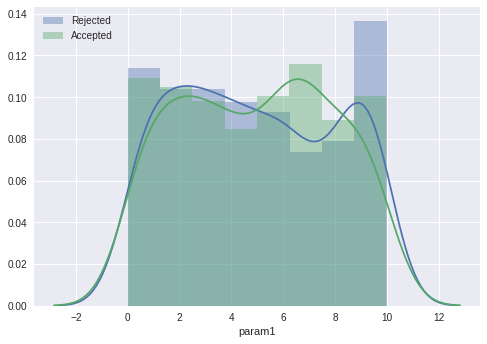

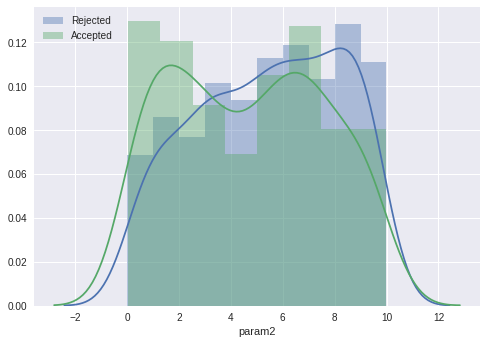

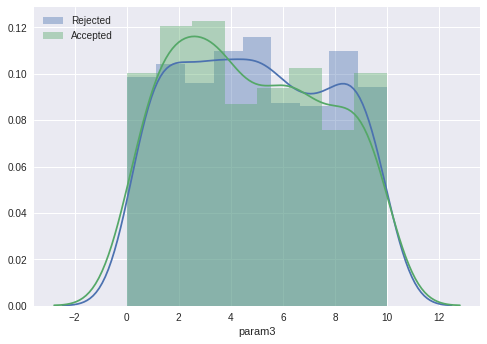

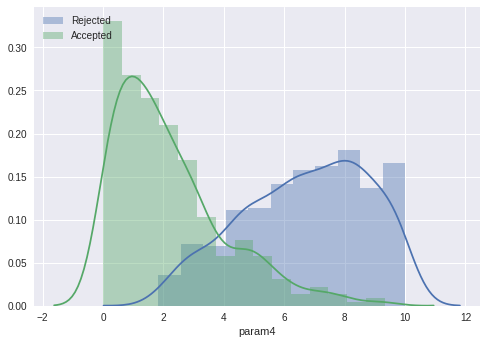

In [4]:
epsilon = 1000
n = 1000 #iteration within the ABC
df = ABC(GKPriorSampler, GKLiklihoodSimulator, GKSummary, epsilon, data , n) #run ABC
print len(df[df.accept==1].index)

df['param1'] = df['theta'].apply(lambda x: x[0]) #selecting the FIRST parameter of the par list (A) 
                                                 #and assigning it to a new col of df
df['param2'] = df['theta'].apply(lambda x: x[1]) #selecting the SECOND parameter of the par list (B) 
                                                 #and assigning it to a new col of df
df['param3'] = df['theta'].apply(lambda x: x[2]) #selecting the SECOND parameter of the par list (G) 
                                                 #and assigning it to a new col of df
df['param4'] = df['theta'].apply(lambda x: x[3]) #selecting the SECOND parameter of the par list (k) 
                                                 #and assigning it to a new col of df
             
######
# plot the accepted and rejected params for A
######

fig, ax = plt.subplots()

accept_legend_map = {1:'Accepted',0:'Rejected'}
for accept, sub_df in df.groupby('accept'):
    sns.distplot(sub_df['param1'], ax=ax, kde = True, label=accept_legend_map[accept]) #norm_hist =True,

#plt.axvline(x=post_mean, ymin=0, ymax = 120, linewidth=1, color='k', label='True posterior mean')
plt.legend(loc='upper left')
plt.savefig('plots/GK_example_abc_report_A.pdf')


######
# plot the accepted and rejected params for B
######

fig, ax = plt.subplots()

accept_legend_map = {1:'Accepted',0:'Rejected'}
for accept, sub_df in df.groupby('accept'):
    sns.distplot(sub_df['param2'], ax=ax, kde = True, label=accept_legend_map[accept]) #norm_hist =True,

#plt.axvline(x=post_mean, ymin=0, ymax = 120, linewidth=1, color='k', label='True posterior mean')
plt.legend(loc='upper left')
plt.savefig('plots/GK_example_abc_report_B.pdf')

######
# plot the accepted and rejected params for G
######

fig, ax = plt.subplots()

accept_legend_map = {1:'Accepted',0:'Rejected'}
for accept, sub_df in df.groupby('accept'):
    sns.distplot(sub_df['param3'], ax=ax, kde = True, label=accept_legend_map[accept]) #norm_hist =True,

#plt.axvline(x=post_mean, ymin=0, ymax = 120, linewidth=1, color='k', label='True posterior mean')
plt.legend(loc='upper left')
plt.savefig('plots/GK_example_abc_report_G.pdf')


######
# plot the accepted and rejected params for k
######

fig, ax = plt.subplots()

accept_legend_map = {1:'Accepted',0:'Rejected'}
for accept, sub_df in df.groupby('accept'):
    sns.distplot(sub_df['param4'], ax=ax, kde = True, label=accept_legend_map[accept]) #norm_hist =True,

#plt.axvline(x=post_mean, ymin=0, ymax = 120, linewidth=1, color='k', label='True posterior mean')
plt.legend(loc='upper left')
plt.savefig('plots/GK_example_abc_report_k.pdf')

## Compare results with and w/o post adjustment 

In [20]:
def EpanechnikovKernel(t,delta,c=1):
    if t<=delta:
        return c*(1/delta)*(1-(t/delta)**2)
    else:
        return 0

df_accepted = df[df['accept'] == 1]
#print df_accepted.head
accepted_count = len(df_accepted.index)
#print accepted_count
print shape(data)[0]
if accepted_count <= shape(data)[0]:
    print accepted_count, "is number of accepted thetas"
    
if accepted_count < 2:
    print "Post processing failed; too few accepted values."
    
summary = GKSummary(data)
    
#print df_accepted.statistics
#print Summary

df_accepted.statistics_diff = df_accepted.statistics.apply(lambda x: np.subtract(x,summary))
#print df_accepted.statistics_diff
df_accepted.statistics_diff_abs = df_accepted.statistics_diff.apply(lambda x: np.power(np.sum(np.square(x)),0.5))
#print df_accepted.statistics_diff_abs.shape
#df_accepted.statistics_diff_abs.hist(bins=100)
quantile = df_accepted.statistics_diff_abs.quantile(0.5) # shouled be ok
#plt.show()
#create column with kernal transform
df_accepted.kernel = df_accepted.statistics_diff_abs.apply(lambda x: EpanechnikovKernel(x, delta=quantile)) #diff_abs

mod = LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)
#print type(df_accepted.statistics_diff)
#X = np.array(df_accepted.statistics_diff) #list of vector

#Create X
size = shape(data)[0] #find a clever way to compute this!!!
X = np.empty([accepted_count, size])
i = 0
for row in df_accepted.statistics_diff:
    X[i,] = row
    i += 1

print X
print type(X)
print shape(X)  
#X = df_accepted.statistics_diff.as_matrix()
#X.shape = (shape(X)[0], len(data))  
#X = np.reshape(X, (shape(X)[0], 100))
# df.reset_index().values
y = np.array(df_accepted.param1)
y.shape = (shape(y)[0],1)
print shape(y)
print type(y)
#print y
weights = np.array(df_accepted.kernel)
res = mod.fit(X, y, sample_weight=weights)


10
[[-180.81641557 -163.80674352   -8.00695901 ...,   -1.91651367
    20.15739686  404.15858083]
 [ -38.53536233   -6.83202174   -6.45654769 ...,   38.85122676
   178.81631441  360.38403599]
 [ -10.3217798    -3.01466732   -2.82109721 ...,    2.20495606
    17.67226201  329.45447562]
 ..., 
 [   2.43028175    2.71398199    2.605177   ...,    3.87642046
     6.63312095   58.0714228 ]
 [  -3.39842776   -2.60390494   -1.26912509 ...,   17.57666171
    73.21864755  116.01173801]
 [-185.45785034   -5.99982164    4.14578898 ...,   31.18672879
   323.11140109  553.83873833]]
<type 'numpy.ndarray'>
(360, 10)
(360, 1)
<type 'numpy.ndarray'>


In [ ]:
    accepted_count = len(df_accepted.index)
    if accepted_count < 5:
    	print accepted_count, "is number of accepted thetas"

    if accepted_count < 2:
    	print "Post processing failed; too few accepted values."
    	return 0

    df_accepted.statistics_diff = np.subtract(df_accepted.statistics,Summary(data)) # here a list of vectors
    df_accepted.statistics_diff_abs = np.power(np.sum(np.square(df_accepted.statistics_diff)), 0.5) # we want a vector of distances
    
    #df_accepted.statistics_diff_abs.hist(bins=100)
    quantile = df_accepted.statistics_diff_abs.quantile(q) # shouled be ok
    #plt.show()

    #create column with kernal transform
    df_accepted.kernel = df_accepted.statistics_diff_abs.apply(lambda x: EpanechnikovKernel(x, delta=quantile)) #diff_abs

    #print df_accepted.kernel[df_accepted.kernel > 0.0]

    mod = LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)
    X = np.array(df_accepted.statistics_diff) #list of vector
    X.shape = (shape(X)[0],1)                 #the number of cols is equal to the lenght of the data
    y = np.array(df_accepted.theta)
    y.shape = (shape(y)[0],1)
    weights = np.array(df_accepted.kernel)
    
    if weighted:
        res = mod.fit(X, y, sample_weight=weights)
    else: 
        res = mod.fit(X, y)
    #alpha = res.intercept_[0]
    beta = res.coef_[0][0]  #dimension equal to the size of the data
    beta_stats_diff = beta*df_accepted.statistics_diff # multiplication of: vector * matrix
    beta_stats_diff_array = np.array(beta_stats_diff)  #change the size
    beta_stats_diff_array.shape = (shape(beta_stats_diff_array)[0],1) #change the size
    theta_star = np.subtract(y, beta_stats_diff_array)
    theta_star = np.reshape(theta_star, theta_star.shape[0])
    df_accepted['theta_star'] = theta_star
    

In [62]:

print df.head()

df_A = df.drop('theta', 1)
df_A = df_A.rename(columns={'param1': 'theta'})

df_abc_accepted_post_processed_A = PostProcess(df_A, GKSummary, data, weighted=True)


# df_abc_accepted = df[df.accept == 1]

# df['param1_padj'] = df['theta_star'].apply(lambda x: x[0]) #selecting the FIRST parameter of the par list (A) 
#                                                  #and assigning it to a new col of df
# df['param2_padj'] = df['theta_star'].apply(lambda x: x[1]) #selecting the SECOND parameter of the par list (B) 
#                                                  #and assigning it to a new col of df
# df['param3_padj'] = df['theta_star'].apply(lambda x: x[2]) #selecting the SECOND parameter of the par list (G) 
#                                                  #and assigning it to a new col of df
# df['param4_padj'] = df['theta_star'].apply(lambda x: x[3]) #selecting the SECOND parameter of the par list (k) 
#                                                  #and assigning it to a new col of df

# fig, ax = plt.subplots()

# sns.distplot(df_abc_accepted.theta, ax=ax, kde = True, label='ABC') #norm_hist =True,
# sns.distplot(df_abc_accepted_post_processed.theta_star, ax=ax, kde = True, label='ABC post processed')
# plt.axvline(x=post_mean, ymin=0, ymax = 120, linewidth=1, color='k', label='True posterior mean')
# plt.legend(loc='upper left')
# plt.show()
# plt.savefig('plots/GK_abc_report_postadj.pdf')

   accept                                         statistics  \
0       0  [-1735.75864347, -565.676279714, -199.63953403...   
1       0  [-5503.65031001, -5379.43773638, -3272.1983298...   
2       0  [-1030756774.84, -16090037.3106, -4849824.0449...   
3       1  [-10.0932296593, 1.07482610674, 3.73725594953,...   
4       0  [-11771.9789992, -2179.70004158, -1695.1990135...   

                                               theta  \
0  [8.42897059233, 5.60119626412, 3.78364483924, ...   
1  [2.39300979818, 3.05293154231, 7.15784204323, ...   
2  [0.608239450441, 6.97393554057, 6.03593567751,...   
3  [8.6027190256, 4.25615540043, 7.52410993813, 1...   
4  [7.43959612941, 0.310608182801, 5.99352307968,...   

                                                   z    param1    param2  \
0  [33.2546175657, 5.70690067513, 6.77930182678, ...  8.428971  5.601196   
1  [1.82284894682, 4588.78582406, 1.46029213076, ...  2.393010  3.052932   
2  [-94.4582395879, 9.32562882505, -93963.968184,.

ValueError: operands could not be broadcast together with shapes (16,) (100,) 

In [54]:
def EpanechnikovKernel(t,delta,c=1):
    if t<=delta:
        return c*(1/delta)*(1-(t/delta)**2)
    else:
        return 0
def PostProcessGK(abc_df, Summary, data, name_param = 'param1', q=0.5,  weighted=True):
    df_accepted = df[df['accept'] == 1]
    #print df_accepted.head
    accepted_count = len(df_accepted.index)
    #print accepted_count
    #print shape(data)[0]
    if accepted_count <= shape(data)[0]:
        print accepted_count, "is number of accepted thetas"

    if accepted_count < 2:
        print "Post processing failed; too few accepted values."

    summary = GKSummary(data)

    #print df_accepted.statistics
    #print Summary

    df_accepted.statistics_diff = df_accepted.statistics.apply(lambda x: np.subtract(x,summary))
    #print df_accepted.statistics_diff
    df_accepted.statistics_diff_abs = df_accepted.statistics_diff.apply(lambda x: np.power(np.sum(np.square(x)),0.5))
    #print df_accepted.statistics_diff_abs.shape
    #df_accepted.statistics_diff_abs.hist(bins=100)
    quantile = df_accepted.statistics_diff_abs.quantile(0.5) # shouled be ok
    #plt.show()
    #create column with kernal transform
    df_accepted.kernel = df_accepted.statistics_diff_abs.apply(lambda x: EpanechnikovKernel(x, delta=quantile)) #diff_abs

    mod = LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)
    #print type(df_accepted.statistics_diff)
    #X = np.array(df_accepted.statistics_diff) #list of vector

    #Create X
    size = shape(data)[0] #find a clever way to compute this!!!
    X = np.empty([accepted_count, size])
    i = 0
    for row in df_accepted.statistics_diff:
        X[i,] = row
        i += 1

    #print X
    #print type(X)
    #print shape(X)  
    #X = df_accepted.statistics_diff.as_matrix()
    #X.shape = (shape(X)[0], len(data))  
    #X = np.reshape(X, (shape(X)[0], 100))
    # df.reset_index().values
    y = np.array(df_accepted[name_param])
    y.shape = (shape(y)[0],1)
    #print shape(y)
    #print type(y)
    #print y
    weights = np.array(df_accepted.kernel)
    if weighted:
        res = mod.fit(X, y, sample_weight=weights)
    else: 
        res = mod.fit(X, y)
        
    beta = res.coef_[0]
   
    beta.shape = (shape(beta)[0], 1)
   
    
    part_res = np.matmul(X, beta)
    #print shape(part_res)
    #print shape(y)
    res = np.subtract(y, part_res)
    return res

## Evaluate MSE with varying $\epsilon$

In [46]:
PostProcessGK(df, GKSummary, data)

(360, 1)
(360, 1)


array([[ -4.92019294e+00],
       [  2.44472721e+00],
       [  2.54702915e+00],
       [  3.75502412e+00],
       [  2.52094473e+00],
       [  2.29862901e+00],
       [  3.97046986e+00],
       [  2.92665823e+00],
       [  3.81466062e+00],
       [  3.72645117e+00],
       [  1.31449493e+00],
       [  5.07559063e+00],
       [ -8.62214330e-01],
       [  4.47445439e+00],
       [  2.24501798e+00],
       [  4.60155192e+00],
       [  4.51237953e-01],
       [  4.29596729e+00],
       [  5.20321354e+00],
       [  2.86496253e+00],
       [  4.77462926e-01],
       [  1.87773458e+00],
       [  5.25015730e+00],
       [  3.43027231e+00],
       [  4.56783536e+00],
       [  4.76200742e+00],
       [  6.04941837e-01],
       [  4.89825748e+00],
       [ -4.88717615e+00],
       [  2.72191998e+00],
       [  4.24256095e+00],
       [  2.56076406e+00],
       [  8.22053131e+00],
       [  4.12980596e+00],
       [  7.74557791e+00],
       [  2.87008417e+00],
       [  2.86150235e+00],
 

In [50]:
import pickle
df = pickle.load( open( "data/gk_data_size_100_epsilon_20.p", "rb" ) )
data = pickle.load( open( "data/gk_data.p", "rb" ) )

In [55]:
param1_star = PostProcessGK(df, GKSummary, data)
param2_star = PostProcessGK(df, GKSummary, data, name_param = 'param2')
param3_star = PostProcessGK(df, GKSummary, data, name_param = 'param3')
param4_star = PostProcessGK(df, GKSummary, data, name_param = 'param4')

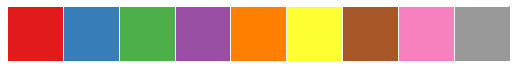

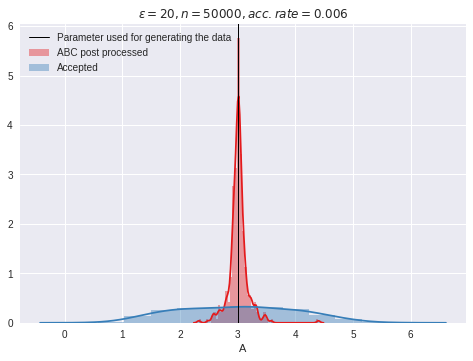

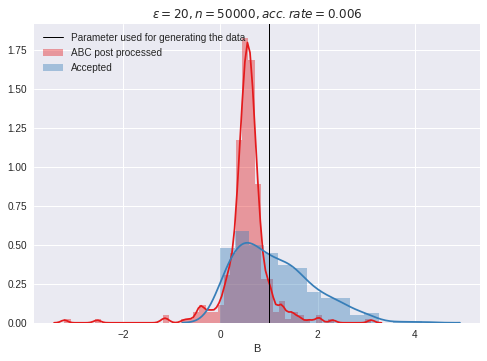

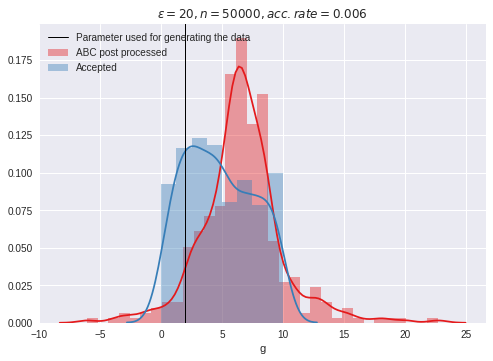

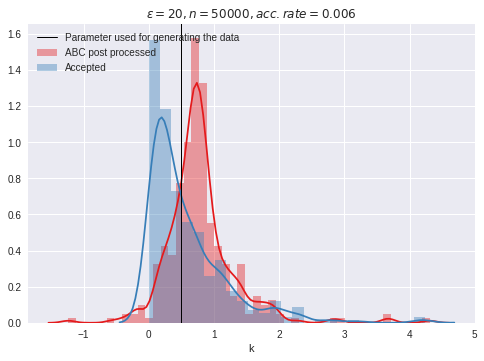

In [74]:
sns.set_palette("Set1")
sns.choose_colorbrewer_palette("qualitative")
df_abc_accepted = df[df.accept == 1]

fig, ax = plt.subplots()

sns.distplot(param1_star, ax=ax, kde = True, label='ABC post processed')

accept_legend_map = {1:'Accepted',0:'Rejected'}
for accept,sub_df in df.groupby('accept'):
    if accept==1:
        sns.distplot(sub_df['param1'], ax=ax, kde = True, label=accept_legend_map[accept]) #norm_hist =True,

plt.axvline(x=3, ymin=0, ymax = 120, linewidth=1, color='k', label='Parameter used for generating the data')
plt.title(r'$\epsilon = {}, n={}, acc.rate={}$'.format(20,50000,0.006))
plt.xlabel('A')
plt.legend(loc='upper left')
plt.savefig('plots/gk_histogram_post_A.pdf')
#################
fig, ax = plt.subplots()

sns.distplot(param2_star, ax=ax, kde = True, label='ABC post processed')

accept_legend_map = {1:'Accepted',0:'Rejected'}
for accept,sub_df in df.groupby('accept'):
    if accept==1:
        sns.distplot(sub_df['param2'], ax=ax, kde = True, label=accept_legend_map[accept]) #norm_hist =True,

plt.axvline(x=1, ymin=0, ymax = 120, linewidth=1, color='k', label='Parameter used for generating the data')
plt.title(r'$\epsilon = {}, n={}, acc.rate={}$'.format(20,50000,0.006))
plt.xlabel('B')
plt.legend(loc='upper left')
plt.savefig('plots/gk_histogram_post_B.pdf')

#################
fig, ax = plt.subplots()

sns.distplot(param3_star, ax=ax, kde = True, label='ABC post processed')

accept_legend_map = {1:'Accepted',0:'Rejected'}
for accept,sub_df in df.groupby('accept'):
    if accept==1:
        sns.distplot(sub_df['param3'], ax=ax, kde = True, label=accept_legend_map[accept]) #norm_hist =True,

plt.axvline(x=2, ymin=0, ymax = 120, linewidth=1, color='k', label='Parameter used for generating the data')
plt.title(r'$\epsilon = {}, n={}, acc.rate={}$'.format(20,50000,0.006))
plt.xlabel('g')
plt.legend(loc='upper left')
plt.savefig('plots/gk_histogram_post_g.pdf')

#################
fig, ax = plt.subplots()

sns.distplot(param4_star, ax=ax, kde = True, label='ABC post processed')

accept_legend_map = {1:'Accepted',0:'Rejected'}
for accept,sub_df in df.groupby('accept'):
    if accept==1:
        sns.distplot(sub_df['param4'], ax=ax, kde = True, label=accept_legend_map[accept]) #norm_hist =True,

plt.axvline(x=0.5, ymin=0, ymax = 120, linewidth=1, color='k', label='Parameter used for generating the data')
plt.title(r'$\epsilon = {}, n={}, acc.rate={}$'.format(20,50000,0.006))
plt.xlabel('k')
plt.legend(loc='upper left')
plt.savefig('plots/gk_histogram_post_k.pdf')